In [1]:
import keras
import quandl
import numpy as np

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

import keras.backend as K
from sklearn.model_selection import KFold

%matplotlib inline

Using TensorFlow backend.


In [2]:
data = quandl.get('BCHARTS/BITFINEXUSD')

In [3]:
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2013-03-31,93.250000,100.000000,93.03000,93.100000,390.827224,3.708933e+04,94.899563
2013-04-01,93.170000,105.900000,92.49999,102.370000,4919.654127,4.921010e+05,100.027564
2013-04-02,102.800000,118.388067,99.00000,117.989990,9084.832816,9.874119e+05,108.687953
2013-04-03,116.579097,146.880000,101.51088,134.952969,12909.402178,1.652092e+06,127.975861
2013-04-04,131.779686,143.000000,119.00000,132.681000,6910.100414,9.094385e+05,131.610029


In [4]:
print(data.shape)
#1363,7

mean = data.mean(axis=0)
std = data.std(axis=0)

# normalizando os dados (zscore normalization)
data = ( data - mean ) / std

X = np.zeros((1363,6,7))

#deslocamento
d = 6

#tirando as d primeiras linhas que estao vazias por causa do deslocamento
for i in range(d,data.shape[0]):
    X[i,:,:] = data.iloc[i-d:i].values

#tirando as d primeiras linhas q tao vazias
X = X[d:,:,:]

print(X.shape)

(1363, 7)
(1357, 6, 7)


In [5]:
# criando as labels
Y = data['Weighted Price'] - data.shift(1)['Weighted Price']

Y.shape

(1363,)

In [6]:
Y = Y > 0

#retirando a primeira linha, pois a segunda label refere-se ao primeiro registro (variacao)
Y = Y[1:]

#retirando as d primeiras datas por causa do deslocamento
Y = Y[d:]

In [7]:
#retirando o ultimo registro das features para 
#especificando as outras dimensoes por boas praticas (nao esquecer a matriz)
X = X[: -1,:,:]

In [8]:
# checking shapes
Y.shape, X.shape

((1356,), (1356, 6, 7))

In [9]:
# passando pro formato de 4 dimensoes esperadas
X = X.reshape((1356,6,7,1))

In [19]:
# train / test split
#X_train = X[:-300,:,:,:]
#X_test = X[-300:,:,:,:]
#Y_train = Y[:-300]
#Y_test = Y[-300:]

# trying some cross validation
kf = KFold(n_splits=20,shuffle=True,random_state=0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    #print("TRAIN:", train_index, "TEST:", test_index)

In [20]:
def model(input_shape):
    
    X_input = Input(input_shape)
    
    #padding same pra nao reduzir 
    X = Conv2D(10,(3,3), strides=(1,1),name="conv0", padding="same")(X_input)
    X = BatchNormalization(axis=3,name='bn0')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2,2),name='max_pool0')(X)
    
    #Second conv
    X = Conv2D(30,(2,2), strides=(1,1),name="conv1", padding="same")(X)
    X = BatchNormalization(axis=3,name='bn1')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2,2),name='max_pool1')(X)
    
    #Third conv
    #X = Conv2D(50,(1,1), strides=(1,1),name="conv2", padding="same")(X)
    #X = BatchNormalization(axis=3,name='bn2')(X)
    #X = Activation('relu')(X)
    
    #fcs
    X = Flatten()(X)
    X = Dense(200,activation="relu")(X)
    X = Dense(100,activation="relu")(X)
    X = Dense(50,activation="relu")(X)
    X = Dense(1,activation="sigmoid")(X)
    
    model = Model(inputs=X_input,outputs=X, name="model1")
    
    return model

In [21]:
#instanciando modelo
model = model(X[0].shape)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=["accuracy"])

model.fit(x = X_train, y = Y_train, epochs = 200, batch_size = 8,verbose=2)

Epoch 1/200
1289/1289 [==============================] - 1s 682us/step - loss: 0.7060 - acc: 0.5128
Epoch 2/200
1289/1289 [==============================] - 1s 493us/step - loss: 0.6953 - acc: 0.5237
Epoch 3/200
1289/1289 [==============================] - 1s 481us/step - loss: 0.6931 - acc: 0.5027
Epoch 4/200
1289/1289 [==============================] - 1s 500us/step - loss: 0.6951 - acc: 0.5229
Epoch 5/200
1289/1289 [==============================] - 1s 501us/step - loss: 0.6942 - acc: 0.5198
Epoch 6/200
1289/1289 [==============================] - 1s 517us/step - loss: 0.6907 - acc: 0.5407
Epoch 7/200
1289/1289 [==============================] - 1s 509us/step - loss: 0.6917 - acc: 0.5345
Epoch 8/200
1289/1289 [==============================] - 1s 498us/step - loss: 0.6920 - acc: 0.5221
Epoch 9/200
1289/1289 [==============================] - 1s 519us/step - loss: 0.6898 - acc: 0.5369
Epoch 10/200
1289/1289 [==============================] - 1s 587us/step - loss: 0.6872 - acc: 0.5423

1289/1289 [==============================] - 1s 515us/step - loss: 0.4833 - acc: 0.7153
Epoch 83/200
1289/1289 [==============================] - 1s 509us/step - loss: 0.4979 - acc: 0.7316
Epoch 84/200
1289/1289 [==============================] - 1s 593us/step - loss: 0.4685 - acc: 0.7324
Epoch 85/200
1289/1289 [==============================] - 1s 548us/step - loss: 0.4795 - acc: 0.7370
Epoch 86/200
1289/1289 [==============================] - 1s 572us/step - loss: 0.4786 - acc: 0.7316
Epoch 87/200
1289/1289 [==============================] - 1s 478us/step - loss: 0.4538 - acc: 0.7424
Epoch 88/200
1289/1289 [==============================] - 1s 485us/step - loss: 0.4661 - acc: 0.7370
Epoch 89/200
1289/1289 [==============================] - 1s 470us/step - loss: 0.4796 - acc: 0.7261
Epoch 90/200
1289/1289 [==============================] - 1s 478us/step - loss: 0.4516 - acc: 0.7580
Epoch 91/200
1289/1289 [==============================] - 1s 491us/step - loss: 0.4686 - acc: 0.7246
Epo

1289/1289 [==============================] - 1s 503us/step - loss: 0.3500 - acc: 0.8293
Epoch 163/200
1289/1289 [==============================] - 1s 473us/step - loss: 0.3356 - acc: 0.8185
Epoch 164/200
1289/1289 [==============================] - 1s 479us/step - loss: 0.3212 - acc: 0.8239
Epoch 165/200
1289/1289 [==============================] - 1s 486us/step - loss: 0.3091 - acc: 0.8332
Epoch 166/200
1289/1289 [==============================] - 1s 500us/step - loss: 0.3587 - acc: 0.8130
Epoch 167/200
1289/1289 [==============================] - 1s 494us/step - loss: 0.3211 - acc: 0.8332
Epoch 168/200
1289/1289 [==============================] - 1s 484us/step - loss: 0.3102 - acc: 0.8293
Epoch 169/200
1289/1289 [==============================] - 1s 513us/step - loss: 0.3648 - acc: 0.8216
Epoch 170/200
1289/1289 [==============================] - 1s 483us/step - loss: 0.3243 - acc: 0.8317
Epoch 171/200
1289/1289 [==============================] - 1s 501us/step - loss: 0.3095 - acc: 0

In [22]:
preds = model.evaluate(x = X_test, y = Y_test)
print()
print("Loss = " + str(preds[0]))
print("Acc = " + str(preds[1]))

67/67 [==============================] - 0s 2ms/step

Loss = 1.5198583634
Acc = 0.626865672531


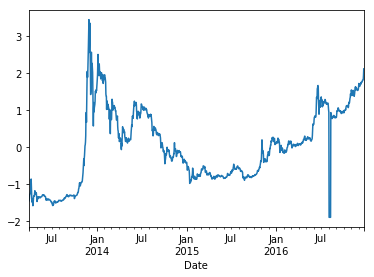

In [15]:
data['Weighted Price'].plot()